# Import necessary libraries

In [1]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
# libaries to help with data visualization
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

#Library for missing values
import missingno as msno

# Library to split data
from sklearn.model_selection import train_test_split
# library to import to standardize the data
from sklearn.preprocessing import MinMaxScaler
#To import different metrics
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, mean_absolute_error, make_scorer
#Importing classback API
from keras import callbacks
# Importing tensorflow library
import tensorflow as tf

# importing different functions to build models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout,InputLayer, Input
from tensorflow.keras.models import Sequential
# Importing Batch Normalization
from keras.layers import BatchNormalization
# Importing backend
from tensorflow.keras import backend
# Importing shffule
import random
from random import shuffle
from keras.callbacks import ModelCheckpoint
# Importing optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from  tensorflow.keras.optimizers import SGD

#Gridsearch for hyperparameter optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.neural_network import MLPRegressor
import scikeras
from scikeras.wrappers import KerasRegressor

#Import Shap
import shap

# Library to avoid the warnings
import warnings
warnings.filterwarnings("ignore")

# Data loading & overview 

In [2]:
All = pd.ExcelFile('allData.xls')
data = pd.read_excel(All, 'Data')
data

,Number,Data source,Selected,Mix number in literature,ASTM type 1 ordinary Portland Cement content (kg/m^3),CEM I 42.5N ordinary Portland Cement content (kg/m^3),CEM I 52.5N ordinary Portland Cement content (kg/m^3),Class C Fly ash content (kg/m^3),Class F Fly ash content (kg/m^3),Slag content (kg/m^3),...,Annual average temperature of exposed environment (Celsius degree),Annual wetting times/rainy days of exposed environment (d),Annual average precipitation of exposed environment (mm),Slump (mm),Average 28-day compressive strength (Mpa),Average 28-day split strength (Mpa),Chloride diffusion coefficient (10-12 m2/s),Average carbonation coefficient (mm/year^0.5),Specimen size,Note
0,NaN,2. Yunusa 2014,NaN,PC-40,0.0,0.0,450.0,0.0,0.0,0.0,...,24.3,0.0,0.0,30.0,75.93,NaN,NaN,3.139,NaN,No significant effect of initial water curing ...
1,NaN,2. Yunusa 2014,NaN,PC-50,0.0,0.0,400.0,0.0,0.0,0.0,...,24.3,0.0,0.0,60.0,64.50,NaN,NaN,4.022,NaN,NaN
2,NaN,2. Yunusa 2014,NaN,PC-60,0.0,0.0,350.0,0.0,0.0,0.0,...,24.3,0.0,0.0,100.0,49.23,NaN,NaN,6.670,NaN,NaN
3,NaN,2. Yunusa 2014,NaN,PC-75,0.0,0.0,300.0,0.0,0.0,0.0,...,24.3,0.0,0.0,140.0,36.00,NaN,NaN,7.945,NaN,NaN
4,NaN,2. Yunusa 2014,NaN,FA-40,0.0,0.0,315.0,0.0,135.0,0.0,...,24.3,0.0,0.0,40.0,62.80,NaN,NaN,6.052,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1983,NaN,"J48. Farahani, 2015",NaN,W3-4,350.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.550,NaN,150*150*150,NaN
1984,NaN,"J48. Farahani, 2015",NaN,W4-1,380.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,3.375,NaN,150*150*150,NaN
1985,NaN,"J48. Farahani, 2015",NaN,W4-2,370.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,150*150*150,NaN
1986,NaN,"J48. Farahani, 2015",NaN,W4-3,360.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.500,NaN,150*150*150,NaN


In [3]:
data.isnull().sum()

Number                                                                1988
Data source                                                              0
Selected                                                              1794
Mix number in literature                                                 0
ASTM type 1 ordinary Portland Cement content (kg/m^3)                    0
CEM I 42.5N ordinary Portland Cement content (kg/m^3)                    0
CEM I 52.5N ordinary Portland Cement content (kg/m^3)                    0
Class C Fly ash content (kg/m^3)                                         0
Class F Fly ash content (kg/m^3)                                         0
Slag content (kg/m^3)                                                    0
Silica fume content (kg/m^3)                                             0
Water content (kg/m^3)                                                   0
Superplasticizer content (kg/m^3)                                        0
Maximum coarse aggregate 

In [4]:
Excess_col_indices = [0] + list(range(2, 4)) + list(range(20, 27)) + [33]
semi_df = data.iloc[:, [col for col in range(data.shape[1]) if col not in Excess_col_indices]]
semi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 0 to 1987
Data columns (total 23 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Data source                                            1988 non-null   object 
 1   ASTM type 1 ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 2   CEM I 42.5N ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 3   CEM I 52.5N ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 4   Class C Fly ash content (kg/m^3)                       1988 non-null   float64
 5   Class F Fly ash content (kg/m^3)                       1988 non-null   float64
 6   Slag content (kg/m^3)                                  1988 non-null   float64
 7   Silica fume content (kg/m^3)                           1988 non-null   float64
 8   Water content (kg/m^3)                          

# Quick fix on the compressive strength and use converted strength

In [5]:
filtered_row = semi_df[semi_df['Average 28-day compressive strength (Mpa)'] > 400]

if len(filtered_row) == 1:
    value_to_divide = filtered_row['Average 28-day compressive strength (Mpa)'].values[0]
    updated_value = value_to_divide / 10

    # Update the value in the DataFrame
    semi_df.loc[semi_df['Average 28-day compressive strength (Mpa)'] > 400, 'Average 28-day compressive strength (Mpa)'] = updated_value
else:
    print("No rows or multiple rows matching the condition.")

In [6]:
semi_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ASTM type 1 ordinary Portland Cement content (kg/m^3),1988.0,39.317656,106.825528,0.00,0.000000,0.000000,0.000000,702.000
CEM I 42.5N ordinary Portland Cement content (kg/m^3),1988.0,95.567020,146.591457,0.00,0.000000,0.000000,210.000000,547.000
CEM I 52.5N ordinary Portland Cement content (kg/m^3),1988.0,147.092807,152.375401,0.00,0.000000,155.000000,280.000000,660.000
Class C Fly ash content (kg/m^3),1988.0,6.120221,28.791545,0.00,0.000000,0.000000,0.000000,225.000
Class F Fly ash content (kg/m^3),1988.0,35.497918,65.744896,0.00,0.000000,0.000000,56.500000,544.000
Slag content (kg/m^3),1988.0,34.629970,73.837709,0.00,0.000000,0.000000,0.000000,440.000
Silica fume content (kg/m^3),1988.0,7.592819,21.082168,0.00,0.000000,0.000000,0.000000,150.000
Water content (kg/m^3),1988.0,172.241112,28.371606,105.00,153.000000,170.000000,186.000000,295.000
Superplasticizer content (kg/m^3),1988.0,2.335606,4.726357,0.00,0.000000,0.000000,2.702500,35.100
Maximum coarse aggregate size (mm),1988.0,18.122485,3.828674,9.50,16.000000,20.000000,20.000000,30.000


In [7]:
## Conversion with specimen size
# Follow the same conversion factor from Compressive strength.ipynb
conversion_factors = {
    '150*150*150': 1.0,
    '200h*100r': {
        (15, 44): 1.21,
        (45, 54): 1.17,
        (55, 64): 1.12,
        (65, 74): 1.10,
        (75, 84): 1.08,
        (85, 94): 1.06,
        (95, 104): 1.04,  # Guess, out of range
        (105, 114): 1.02,
    },
    '100*100*100': 0.95,
    '100*100*300': {},  # No suitable conversion index available
    '300h*150r': {
        (15, 44): 1.32,
        (45, 54): 1.32,
        (55, 64): 1.28,
        (65, 74): 1.25,
        (75, 84): 1.22,
        (85, 94): 1.19,
        (95, 104): 1.16,
        (105, 114): 1.13,
    },
    '100h*100r': {},  # No suitable conversion index available
}


def convert_strength(row):
    size = row['Specimen size']
    strength = row['Average 28-day compressive strength (Mpa)']

    original_size = size  # Store the original size

    if size in conversion_factors:
        factor = conversion_factors[size]

        if isinstance(factor, dict):
            for range_, conversion_factor in factor.items():
                lower_bound, upper_bound = range_
                if lower_bound <= strength < upper_bound:
                    return strength * conversion_factor
        else:
            return strength * factor

    return strength


# Apply the conversion function to the DataFrame
semi_df['Converted Strength'] = semi_df.apply(convert_strength, axis=1)

# Print the updated DataFrame
print(semi_df)

              Data source  \
0          2. Yunusa 2014   
1          2. Yunusa 2014   
2          2. Yunusa 2014   
3          2. Yunusa 2014   
4          2. Yunusa 2014   
...                   ...   
1983  J48. Farahani, 2015   
1984  J48. Farahani, 2015   
1985  J48. Farahani, 2015   
1986  J48. Farahani, 2015   
1987  J48. Farahani, 2015   

      ASTM type 1 ordinary Portland Cement content (kg/m^3)  \
0                                                   0.0       
1                                                   0.0       
2                                                   0.0       
3                                                   0.0       
4                                                   0.0       
...                                                 ...       
1983                                              350.0       
1984                                              380.0       
1985                                              370.0       
1986                 

In [8]:
semi_df['Converted Strength']

0       75.93
1       64.50
2       49.23
3       36.00
4       62.80
        ...  
1983      NaN
1984      NaN
1985      NaN
1986      NaN
1987      NaN
Name: Converted Strength, Length: 1988, dtype: float64

In [9]:
semi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 0 to 1987
Data columns (total 24 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Data source                                            1988 non-null   object 
 1   ASTM type 1 ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 2   CEM I 42.5N ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 3   CEM I 52.5N ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 4   Class C Fly ash content (kg/m^3)                       1988 non-null   float64
 5   Class F Fly ash content (kg/m^3)                       1988 non-null   float64
 6   Slag content (kg/m^3)                                  1988 non-null   float64
 7   Silica fume content (kg/m^3)                           1988 non-null   float64
 8   Water content (kg/m^3)                          

In [10]:
semi_df = semi_df.drop(['Average 28-day compressive strength (Mpa)', 'Specimen size', 'Curing humidity (%)'], axis = 1)
semi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 0 to 1987
Data columns (total 21 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Data source                                            1988 non-null   object 
 1   ASTM type 1 ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 2   CEM I 42.5N ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 3   CEM I 52.5N ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 4   Class C Fly ash content (kg/m^3)                       1988 non-null   float64
 5   Class F Fly ash content (kg/m^3)                       1988 non-null   float64
 6   Slag content (kg/m^3)                                  1988 non-null   float64
 7   Silica fume content (kg/m^3)                           1988 non-null   float64
 8   Water content (kg/m^3)                          

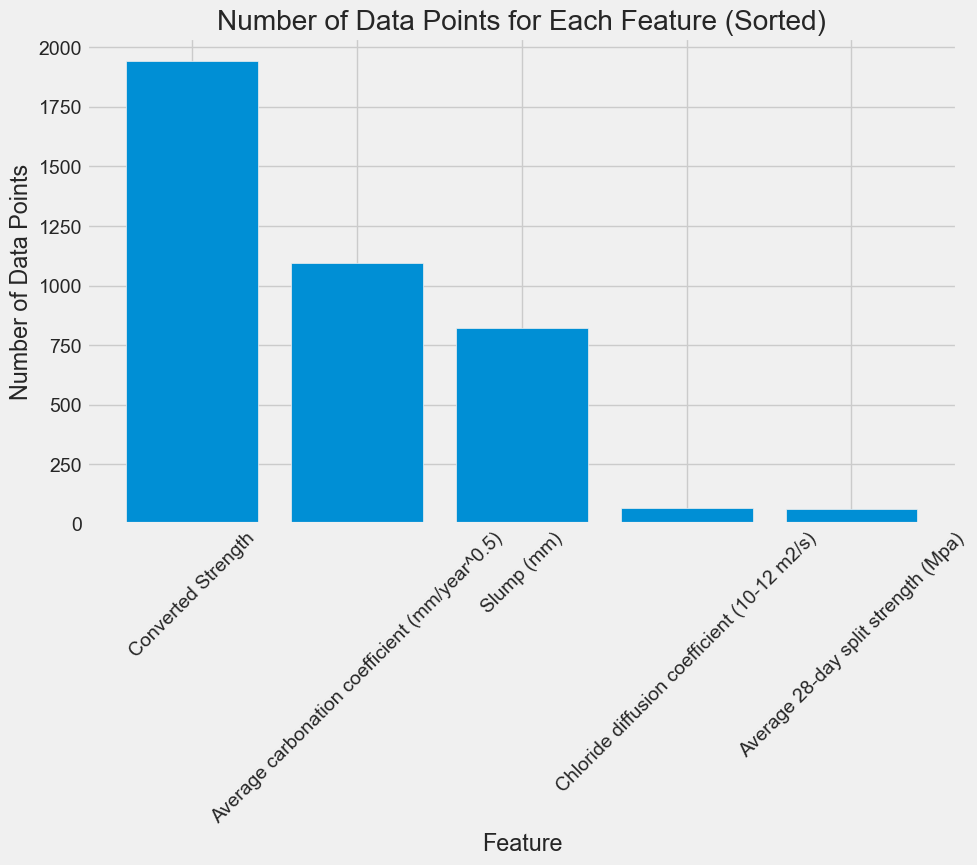

In [11]:
# Subset the DataFrame with the columns of interest
subset_df = semi_df[['Slump (mm)', 'Average 28-day split strength (Mpa)',
                     'Chloride diffusion coefficient (10-12 m2/s)',
                     'Average carbonation coefficient (mm/year^0.5)',
                     'Converted Strength']]

# Calculate the number of data points for each feature
counts = subset_df.count()

# Sort the counts in descending order
sorted_counts = counts.sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_counts.index, sorted_counts.values)

# Set plot labels and title
plt.xlabel('Feature')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points for Each Feature (Sorted)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

# Curing method

In [12]:
missing = semi_df['Curing method'].isnull()
semi_df[missing]

,Data source,ASTM type 1 ordinary Portland Cement content (kg/m^3),CEM I 42.5N ordinary Portland Cement content (kg/m^3),CEM I 52.5N ordinary Portland Cement content (kg/m^3),Class C Fly ash content (kg/m^3),Class F Fly ash content (kg/m^3),Slag content (kg/m^3),Silica fume content (kg/m^3),Water content (kg/m^3),Superplasticizer content (kg/m^3),...,Coarse aggregate content (kg/m^3),Fine aggregate content (kg/m^3),Curing method,Curing temperature (Celsius degree),Curing day,Slump (mm),Average 28-day split strength (Mpa),Chloride diffusion coefficient (10-12 m2/s),Average carbonation coefficient (mm/year^0.5),Converted Strength
1946,"J45. Kayali, 2012",0.0,450.0,0.0,0.0,0.0,0.0,0.0,171.0,5.130,...,1110.0,680.0,NaN,NaN,NaN,65.0,NaN,NaN,NaN,NaN
1947,"J45. Kayali, 2012",0.0,405.0,0.0,0.0,0.0,0.0,45.0,171.0,5.850,...,1101.0,675.0,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN
1948,"J45. Kayali, 2012",0.0,337.5,0.0,0.0,0.0,112.5,0.0,171.0,5.850,...,1105.0,677.0,NaN,NaN,NaN,200.0,NaN,NaN,NaN,NaN
1949,"J45. Kayali, 2012",0.0,292.5,0.0,0.0,0.0,112.5,45.0,171.0,5.895,...,1096.0,672.0,NaN,NaN,NaN,90.0,NaN,NaN,NaN,NaN
1950,"J45. Kayali, 2012",0.0,225.0,0.0,0.0,0.0,225.0,0.0,171.0,5.400,...,1100.0,674.0,NaN,NaN,NaN,35.0,NaN,NaN,NaN,NaN
1951,"J45. Kayali, 2012",0.0,180.0,0.0,0.0,0.0,225.0,45.0,171.0,5.850,...,1091.0,669.0,NaN,NaN,NaN,130.0,NaN,NaN,NaN,NaN
1952,"J45. Kayali, 2012",0.0,135.0,0.0,0.0,0.0,315.0,0.0,171.0,4.230,...,1111.0,681.0,NaN,NaN,NaN,155.0,NaN,NaN,NaN,NaN
1953,"J45. Kayali, 2012",0.0,90.0,0.0,0.0,0.0,315.0,45.0,171.0,5.850,...,1102.0,675.0,NaN,NaN,NaN,110.0,NaN,NaN,NaN,NaN


In [13]:
semi_df = semi_df.dropna(subset = ['Curing method'])
new_df = semi_df.copy()
new_df = pd.concat([semi_df, pd.get_dummies(semi_df['Curing method'])], axis=1)
new_df.isnull().sum()

Data source                                                 0
ASTM type 1 ordinary Portland Cement content (kg/m^3)       0
CEM I 42.5N ordinary Portland Cement content (kg/m^3)       0
CEM I 52.5N ordinary Portland Cement content (kg/m^3)       0
Class C Fly ash content (kg/m^3)                            0
Class F Fly ash content (kg/m^3)                            0
Slag content (kg/m^3)                                       0
Silica fume content (kg/m^3)                                0
Water content (kg/m^3)                                      0
Superplasticizer content (kg/m^3)                           0
Maximum coarse aggregate size (mm)                          0
Coarse aggregate content (kg/m^3)                           5
Fine aggregate content (kg/m^3)                             5
Curing method                                               0
Curing temperature (Celsius degree)                         0
Curing day                                                  2
Slump (m

In [14]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1980 entries, 0 to 1987
Data columns (total 25 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Data source                                            1980 non-null   object 
 1   ASTM type 1 ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 2   CEM I 42.5N ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 3   CEM I 52.5N ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 4   Class C Fly ash content (kg/m^3)                       1980 non-null   float64
 5   Class F Fly ash content (kg/m^3)                       1980 non-null   float64
 6   Slag content (kg/m^3)                                  1980 non-null   float64
 7   Silica fume content (kg/m^3)                           1980 non-null   float64
 8   Water content (kg/m^3)                          

In [15]:
new_df = new_df.drop(['Curing method', 'Curing day'], axis= 1)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1980 entries, 0 to 1987
Data columns (total 23 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Data source                                            1980 non-null   object 
 1   ASTM type 1 ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 2   CEM I 42.5N ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 3   CEM I 52.5N ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 4   Class C Fly ash content (kg/m^3)                       1980 non-null   float64
 5   Class F Fly ash content (kg/m^3)                       1980 non-null   float64
 6   Slag content (kg/m^3)                                  1980 non-null   float64
 7   Silica fume content (kg/m^3)                           1980 non-null   float64
 8   Water content (kg/m^3)                          

# Gaussian Process

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [17]:
#chloride = new_df.drop(['Slump (mm)', 'Converted Strength', 'Slump (mm)', 'Average 28-day split strength (Mpa)', 'Average carbonation coefficient (mm/year^0.5)', 'Data source'], axis= 1)
#chloride

In [18]:
chloride = new_df.drop(['Slump (mm)', 'Chloride diffusion coefficient (10-12 m2/s)', 'Slump (mm)', 'Average 28-day split strength (Mpa)', 'Average carbonation coefficient (mm/year^0.5)', 'Data source'], axis= 1)
chloride # Strength

,ASTM type 1 ordinary Portland Cement content (kg/m^3),CEM I 42.5N ordinary Portland Cement content (kg/m^3),CEM I 52.5N ordinary Portland Cement content (kg/m^3),Class C Fly ash content (kg/m^3),Class F Fly ash content (kg/m^3),Slag content (kg/m^3),Silica fume content (kg/m^3),Water content (kg/m^3),Superplasticizer content (kg/m^3),Maximum coarse aggregate size (mm),Coarse aggregate content (kg/m^3),Fine aggregate content (kg/m^3),Curing temperature (Celsius degree),Converted Strength,Air,Moist,Sealed,Submerged
0,0.0,0.0,450.0,0.0,0.0,0.0,0.0,180.0,4.00,20.0,990.0,800.0,20.0,75.93,0,0,0,1
1,0.0,0.0,400.0,0.0,0.0,0.0,0.0,200.0,3.25,20.0,990.0,877.0,20.0,64.50,0,0,0,1
2,0.0,0.0,350.0,0.0,0.0,0.0,0.0,210.0,0.00,20.0,1015.0,869.0,20.0,49.23,0,0,0,1
3,0.0,0.0,300.0,0.0,0.0,0.0,0.0,225.0,0.00,20.0,1050.0,810.0,20.0,36.00,0,0,0,1
4,0.0,0.0,315.0,0.0,135.0,0.0,0.0,180.0,1.75,20.0,990.0,800.0,20.0,62.80,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1983,350.0,0.0,0.0,0.0,0.0,0.0,50.0,180.0,2.00,20.0,983.0,806.0,21.0,NaN,0,0,0,1
1984,380.0,0.0,0.0,0.0,0.0,0.0,20.0,200.0,0.80,20.0,991.0,793.0,21.0,NaN,0,0,0,1
1985,370.0,0.0,0.0,0.0,0.0,0.0,30.0,200.0,1.20,20.0,959.0,784.0,21.0,NaN,0,0,0,1
1986,360.0,0.0,0.0,0.0,0.0,0.0,40.0,200.0,1.80,20.0,1020.0,820.0,21.0,NaN,0,0,0,1


In [22]:
chloride = chloride.dropna()

x_chl = chloride.drop('Converted Strength', axis=1) # Converted Strength
y_chl = chloride['Converted Strength']
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(x_chl, y_chl, test_size=0.2, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define and train Gaussian Process Regression model
kernel = 1.0 * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, random_state=42)
gpr.fit(X_train, y_train)

# Generate new data points
# For example, let's generate 10 new data points
new_data_points = np.random.rand(400, x_chl.shape[1])  # Generate random feature values
predictions, std_dev = gpr.predict(new_data_points, return_std=True)  # Predictions and uncertainty

In [23]:
y_pred = gpr.predict(X_test)

# Compute regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 1493.2571422508752
R-squared (R2) Score: -3.075827365484389
Mean Absolute Error (MAE): 24.083312256429146


In [24]:
y_pred

array([40.42857143, 65.8       ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , 19.187     , 37.        , 46.        ,
        0.        ,  0.        , 38.14285714, 59.202     ,  0.        ,
       52.38095238,  0.        , 22.8       , 53.57142857, 68.75      ,
       36.        ,  0.        , 49.57142857, 46.42857143,  0.        ,
       60.42857143,  0.        ,  0.        ,  0.        , 42.85714286,
       48.42857143,  0.        ,  0.        ,  0.        , 57.57142857,
       48.        , 24.3       ,  0.        ,  0.        , 29.        ,
       60.        ,  0.        , 41.4       , 56.14285714,  0.        ,
       48.42857143,  0.        , 68.14285714, 38.        , 49.42857143,
       72.38095238,  0.        ,  0.        , 44.        , 25.25      ,
       51.25      , 48.85714286, 79.04761905,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , 69.28571429,
        0.        , 43.71428571,  0.        , 37.8       ,  0.  

In [20]:
generated_data = pd.DataFrame(new_data_points, columns=x_chl.columns)
generated_data['Predicted_Chloride'] = predictions
generated_data['Standard_Deviation'] = std_dev

generated_data

,ASTM type 1 ordinary Portland Cement content (kg/m^3),CEM I 42.5N ordinary Portland Cement content (kg/m^3),CEM I 52.5N ordinary Portland Cement content (kg/m^3),Class C Fly ash content (kg/m^3),Class F Fly ash content (kg/m^3),Slag content (kg/m^3),Silica fume content (kg/m^3),Water content (kg/m^3),Superplasticizer content (kg/m^3),Maximum coarse aggregate size (mm),Coarse aggregate content (kg/m^3),Fine aggregate content (kg/m^3),Curing temperature (Celsius degree),Air,Moist,Sealed,Submerged,Predicted_Chloride,Standard_Deviation
0,0.237008,0.107721,0.273616,0.896487,0.834235,0.497559,0.200333,0.142514,0.979702,0.411774,0.735879,0.459499,0.554050,0.953720,0.498374,0.048712,0.956315,0.0,7.857381
1,0.616160,0.458892,0.945487,0.345501,0.597774,0.773139,0.741603,0.269307,0.852647,0.888666,0.943907,0.660987,0.091863,0.161193,0.982306,0.430906,0.070610,0.0,7.857381
2,0.646013,0.407993,0.953196,0.773330,0.683872,0.006197,0.862933,0.633264,0.702009,0.570303,0.436884,0.711851,0.309616,0.467366,0.241378,0.374880,0.470101,0.0,7.857381
3,0.754748,0.803603,0.116355,0.853082,0.457506,0.135159,0.487621,0.487149,0.148963,0.272097,0.459030,0.832134,0.746969,0.230760,0.818973,0.894910,0.463332,0.0,7.857381
4,0.967116,0.058267,0.915526,0.170836,0.762820,0.999654,0.309485,0.399680,0.151769,0.694401,0.998686,0.189484,0.768414,0.911455,0.043711,0.754284,0.180918,0.0,7.857381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.638141,0.752689,0.747245,0.420443,0.507324,0.759044,0.919027,0.130976,0.009821,0.762246,0.760635,0.012087,0.571946,0.065219,0.876255,0.483862,0.890936,0.0,7.857381
396,0.941687,0.915493,0.958980,0.153169,0.131953,0.234336,0.294363,0.071811,0.846536,0.784660,0.292049,0.976525,0.918475,0.111886,0.507224,0.810709,0.526599,0.0,7.857381
397,0.865140,0.546289,0.677459,0.068257,0.009316,0.870257,0.346917,0.924467,0.670824,0.137022,0.466763,0.119242,0.805790,0.441217,0.138015,0.391620,0.822164,0.0,7.857381
398,0.849578,0.208974,0.663022,0.917543,0.800238,0.182468,0.640085,0.380662,0.386179,0.691891,0.337032,0.819836,0.432653,0.105422,0.508973,0.932576,0.374893,0.0,7.857381


In [21]:
# Define the GPR model
gpr = GaussianProcessRegressor()

# Define the parameter grid to search
param_grid = {
    'kernel': [1.0 * RBF(length_scale=1.0),  # RBF kernel with default parameters
               1.0 * RBF(length_scale=0.5),  # RBF kernel with smaller length scale
               ],
    'alpha': [1e-10, 1e-5, 1e-3],  # Noise level (alpha) values to try
}

# Define mean squared error as the scoring metric
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform grid search cross-validation
grid_search = GridSearchCV(gpr, param_grid, scoring=scorer, cv=10)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_gpr_model = grid_search.best_estimator_

# Evaluate the best model on the test data
y_pred = best_gpr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Best Model Mean Squared Error (MSE):", mse)

Best Model Mean Squared Error (MSE): 19.992112399192425


In [22]:
from sklearn.preprocessing import StandardScaler 
# Feature scaling
scaler = StandardScaler()
x_chl_scaled = scaler.fit_transform(x_chl)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_chl_scaled, y_chl, test_size=0.2, random_state=42)

# Define the GPR model
gpr = GaussianProcessRegressor()

# Define the parameter grid to search
param_grid = {
    'kernel': [1.0 * RBF(length_scale=1.0),  # Default RBF kernel
               1.0 * RBF(length_scale=0.5),  # Smaller length scale
               1.0 * RBF(length_scale=0.2),
               1.0 * RBF(length_scale=0.1)
               ],
    'alpha': [1e-10, 1e-5, 1e-3],  # Noise level values to try
}

# Perform grid search cross-validation
grid_search = GridSearchCV(gpr, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_gpr_model = grid_search.best_estimator_

# Evaluate the best model on the test data
y_pred = best_gpr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(grid_search.best_params_)
print("Best Model Mean Squared Error (MSE):", mse)
print("Best Model R-squared (R2) Score:", r2)
print("Best Model Mean Absolute Error (MAE):", mae)

{'alpha': 1e-05, 'kernel': 1**2 * RBF(length_scale=0.2)}
Best Model Mean Squared Error (MSE): 14.894316596010482
Best Model R-squared (R2) Score: 0.3542334213593685
Best Model Mean Absolute Error (MAE): 2.3008598356880636


# Data preparation

In [16]:
new_df = new_df.drop(['Average 28-day split strength (Mpa)', 'Chloride diffusion coefficient (10-12 m2/s)'], axis = 1)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1980 entries, 0 to 1987
Data columns (total 21 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Data source                                            1980 non-null   object 
 1   ASTM type 1 ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 2   CEM I 42.5N ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 3   CEM I 52.5N ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 4   Class C Fly ash content (kg/m^3)                       1980 non-null   float64
 5   Class F Fly ash content (kg/m^3)                       1980 non-null   float64
 6   Slag content (kg/m^3)                                  1980 non-null   float64
 7   Silica fume content (kg/m^3)                           1980 non-null   float64
 8   Water content (kg/m^3)                          

## Drop na

In [17]:
new_df_drop = new_df.dropna()
new_df_drop.isnull().sum()

Data source                                              0
ASTM type 1 ordinary Portland Cement content (kg/m^3)    0
CEM I 42.5N ordinary Portland Cement content (kg/m^3)    0
CEM I 52.5N ordinary Portland Cement content (kg/m^3)    0
Class C Fly ash content (kg/m^3)                         0
Class F Fly ash content (kg/m^3)                         0
Slag content (kg/m^3)                                    0
Silica fume content (kg/m^3)                             0
Water content (kg/m^3)                                   0
Superplasticizer content (kg/m^3)                        0
Maximum coarse aggregate size (mm)                       0
Coarse aggregate content (kg/m^3)                        0
Fine aggregate content (kg/m^3)                          0
Curing temperature (Celsius degree)                      0
Slump (mm)                                               0
Average carbonation coefficient (mm/year^0.5)            0
Converted Strength                                      

In [18]:
new_df_drop.describe().T

,count,mean,std,min,25%,50%,75%,max
ASTM type 1 ordinary Portland Cement content (kg/m^3),505.0,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000
CEM I 42.5N ordinary Portland Cement content (kg/m^3),505.0,69.551089,123.663744,0.000000,0.000,0.000,128.000000,440.000
CEM I 52.5N ordinary Portland Cement content (kg/m^3),505.0,197.544554,136.984533,0.000000,0.000,217.000,297.500000,490.000
Class C Fly ash content (kg/m^3),505.0,2.700990,15.443146,0.000000,0.000,0.000,0.000000,155.000
Class F Fly ash content (kg/m^3),505.0,39.486931,57.978862,0.000000,0.000,0.000,90.000000,225.000
Slag content (kg/m^3),505.0,34.752079,67.452487,0.000000,0.000,0.000,45.000000,253.500
Silica fume content (kg/m^3),505.0,3.251980,10.675975,0.000000,0.000,0.000,0.000000,45.000
Water content (kg/m^3),505.0,175.081208,25.050504,129.000000,155.000,180.000,190.000000,225.000
Superplasticizer content (kg/m^3),505.0,0.864601,1.561394,0.000000,0.000,0.000,1.600000,9.176
Maximum coarse aggregate size (mm),505.0,18.912871,4.614970,10.000000,16.000,20.000,20.000000,30.000


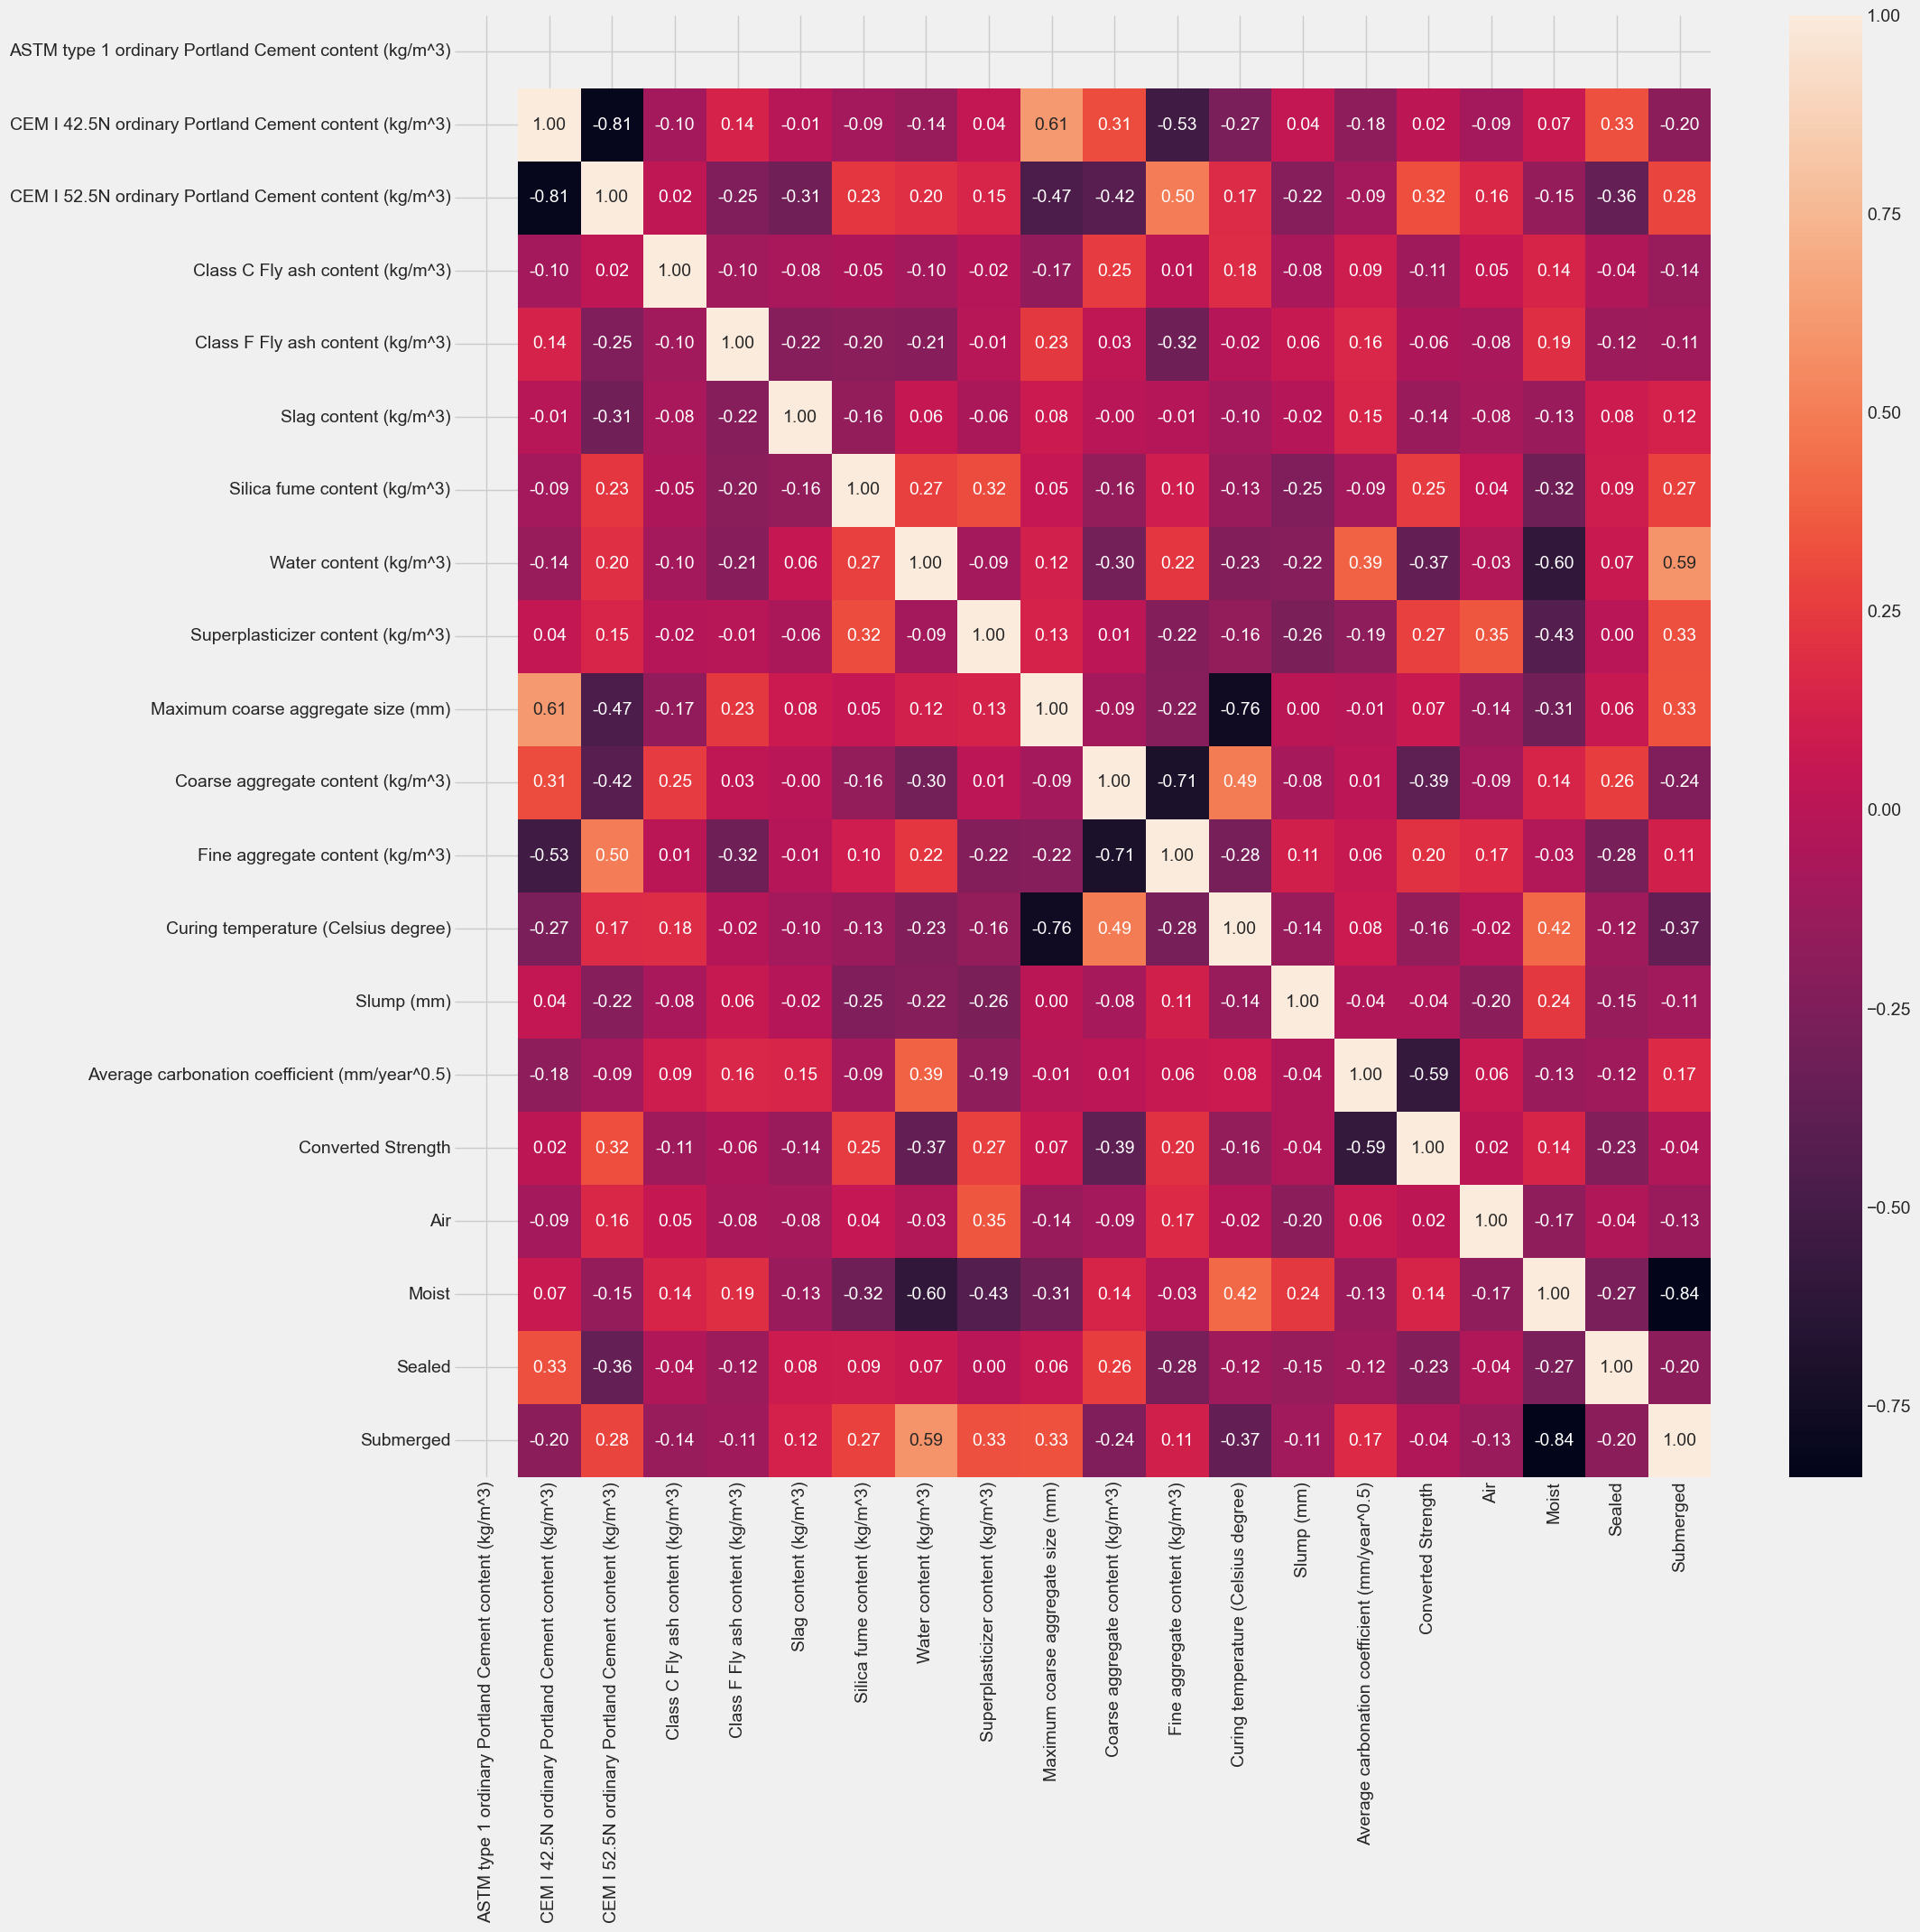

In [19]:
plt.figure(figsize=(20,20))
sns.heatmap(new_df_drop.corr(), annot= True, fmt='.2f', cmap='rocket')
plt.show()

In [ ]:
sns.pairplot(new_df_drop, hue= 'Data source', diag_kind= 'kde')
plt.show()


KeyboardInterrupt



## Train test split

In [20]:
new_df_drop = new_df_drop.drop('Data source', axis = 1)

In [21]:
target = ['Slump (mm)', 'Average carbonation coefficient (mm/year^0.5)','Converted Strength']
feature_cols = [col for col in new_df_drop.columns if col not in target]

feature_df = new_df_drop[feature_cols]
# Extract the target dataframe
target_df = new_df_drop[target]  

In [22]:
feature_df

,ASTM type 1 ordinary Portland Cement content (kg/m^3),CEM I 42.5N ordinary Portland Cement content (kg/m^3),CEM I 52.5N ordinary Portland Cement content (kg/m^3),Class C Fly ash content (kg/m^3),Class F Fly ash content (kg/m^3),Slag content (kg/m^3),Silica fume content (kg/m^3),Water content (kg/m^3),Superplasticizer content (kg/m^3),Maximum coarse aggregate size (mm),Coarse aggregate content (kg/m^3),Fine aggregate content (kg/m^3),Curing temperature (Celsius degree),Air,Moist,Sealed,Submerged
0,0.0,0.0,450.0,0.0,0.0,0.0,0.0,180.0,4.00,20.0,990.0,800.0,20.0,0,0,0,1
1,0.0,0.0,400.0,0.0,0.0,0.0,0.0,200.0,3.25,20.0,990.0,877.0,20.0,0,0,0,1
2,0.0,0.0,350.0,0.0,0.0,0.0,0.0,210.0,0.00,20.0,1015.0,869.0,20.0,0,0,0,1
3,0.0,0.0,300.0,0.0,0.0,0.0,0.0,225.0,0.00,20.0,1050.0,810.0,20.0,0,0,0,1
4,0.0,0.0,315.0,0.0,135.0,0.0,0.0,180.0,1.75,20.0,990.0,800.0,20.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,0.0,86.0,0.0,0.0,86.0,171.0,0.0,151.0,1.71,25.0,1276.0,603.0,20.0,0,0,0,1
1103,0.0,109.0,0.0,0.0,108.0,216.0,0.0,149.0,3.00,25.0,1257.0,541.0,20.0,0,0,0,1
1104,0.0,126.0,0.0,0.0,63.0,62.0,0.0,163.0,1.51,25.0,1251.0,679.0,20.0,0,0,0,1
1105,0.0,171.0,0.0,0.0,85.0,85.0,0.0,151.0,2.05,25.0,1276.0,600.0,20.0,0,0,0,1


In [23]:
target_df

,Slump (mm),Average carbonation coefficient (mm/year^0.5),Converted Strength
0,30.0,3.139000,75.93
1,60.0,4.022000,64.50
2,100.0,6.670000,49.23
3,140.0,7.945000,36.00
4,40.0,6.052000,62.80
...,...,...,...
1102,90.0,5.281004,30.40
1103,240.0,3.573374,52.50
1104,190.0,6.988634,21.00
1105,140.0,3.288769,41.70


In [24]:
X, y = feature_df, target_df
# Get the number of inputs and outputs from the dataset
n_inputs, n_outputs = X.shape[1], y.shape[1]

In [25]:
# Split the data into train and test sets
X_big, X_test, y_big, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Further split the train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_big, y_big, test_size=0.2, random_state=42)

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [26]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [27]:
model = Sequential()
model.add(Dense(128, input_shape=(n_inputs,), kernel_initializer='he_uniform', activation='relu'))
model.add(BatchNormalization())  # Adding BatchNormalization after the first Dense layer
model.add(Dense(32, kernel_initializer='he_uniform', activation='relu'))
model.add(BatchNormalization())  # Adding BatchNormalization after the second Dense layer
model.add(Dense(16, kernel_initializer='he_uniform', activation='relu'))
model.add(BatchNormalization())  # Adding BatchNormalization after the third Dense layer
model.add(Dense(8, kernel_initializer='he_uniform', activation='relu'))
model.add(BatchNormalization())  # Adding BatchNormalization after the fourth Dense layer
model.add(Dense(n_outputs, activation='linear'))

optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=100)   

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 5631.0820 - mae: 54.1607 - val_loss: 5897.4102 - val_mae: 54.9524
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5509.9844 - mae: 53.7883 - val_loss: 5910.7046 - val_mae: 55.2901
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5373.2881 - mae: 53.1773 - val_loss: 6063.4849 - val_mae: 56.5060
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5193.4458 - mae: 52.3097 - val_loss: 6284.1001 - val_mae: 58.1101
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4968.0073 - mae: 51.1961 - val_loss: 6607.7051 - val_mae: 60.4802
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4702.5195 - mae: 49.8079 - val_loss: 7176.8945 - val_mae: 64.2496
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4387.5889 - mae: 48.1396 - val_loss: 8044.1250 - val_mae: 68.7419
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4057.7136 - mae: 46.1106 - val_loss: 9004.3604 - val_mae: 73.4043

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,843 (89.23 KB)

 Trainable params: 7,491 (29.26 KB)

 Non-trainable params: 368 (1.44 KB)

 Optimizer params: 14,984 (58.54 KB)

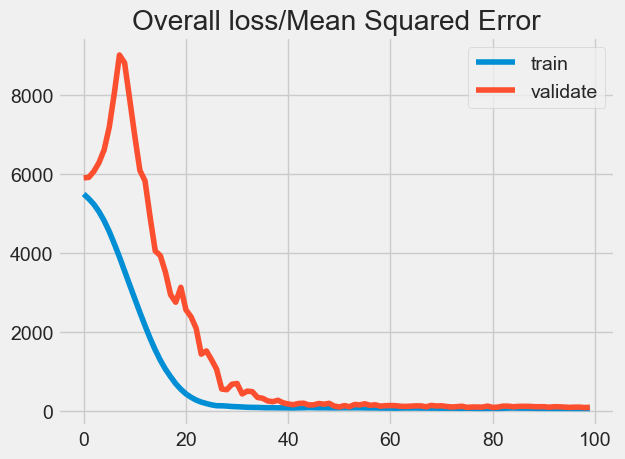

In [29]:
plt.title('Overall loss/Mean Squared Error')
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'validate')
plt.legend()
plt.show()

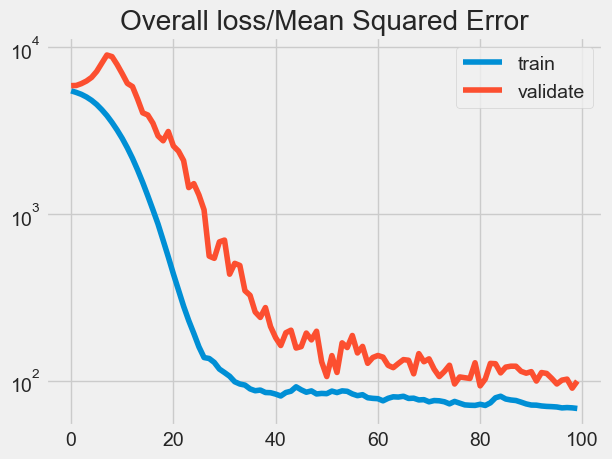

In [30]:
plt.title('Overall loss/Mean Squared Error')
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'validate')
plt.yscale('log')
plt.legend()
plt.show()

In [31]:
# Make predictions on the validation and test sets
val_predictions = model.predict(X_val_scaled)
test_predictions = model.predict(X_test_scaled)

# Calculate RMSE, MAE, R2, and adjusted R2 for the validation set
val_rmse = mean_squared_error(y_val, val_predictions, squared=False)
val_mae = mean_absolute_error(y_val, val_predictions)
val_r2 = r2_score(y_val, val_predictions)
val_adjusted_r2 = 1 - (1 - val_r2) * (len(y_val) - 1) / (len(y_val) - X_val_scaled.shape[1] - 1)

# Calculate RMSE, MAE, R2, and adjusted R2 for the test set
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)
test_adjusted_r2 = 1 - (1 - test_r2) * (len(y_test) - 1) / (len(y_test) - X_test_scaled.shape[1] - 1)

# Create a dataframe to store the results
results_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R2', 'Adjusted R2'],
    'Validation Set': [val_rmse, val_mae, val_r2, val_adjusted_r2],
    'Test Set': [test_rmse, test_mae, test_r2, test_adjusted_r2]
})

# Print the results dataframe
results_df

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


,Metric,Validation Set,Test Set
0,RMSE,8.517399,9.164359
1,MAE,5.761129,5.461538
2,R2,0.653694,0.788348
3,Adjusted R2,0.573047,0.679314


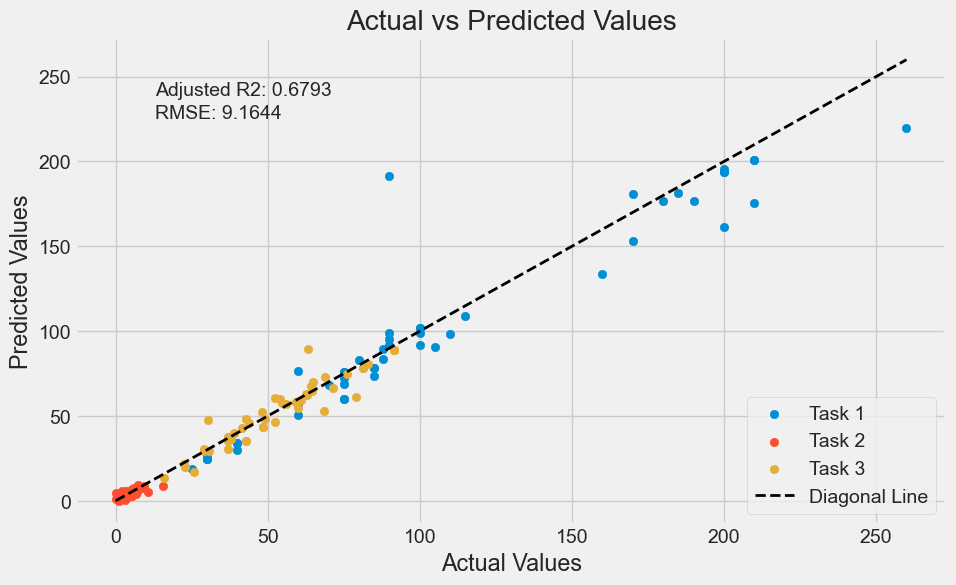

In [32]:
# Convert y_test and test_predictions to numpy arrays
y_test_np = y_test.values


# Plot the graph
plt.figure(figsize=(10, 6))
for i in range(n_outputs):
    plt.scatter(y_test_np[:, i], test_predictions[:, i], label=f'Task {i+1}')

# Plot the diagonal line
max_value = max(np.max(y_test_np), np.max(test_predictions))
plt.plot([0, max_value], [0, max_value], color='black', linestyle='--', label='Diagonal Line', lw=2)

# Set plot labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

# Calculate and display adjusted R2 and RMSE
adj_r2_text = f'Adjusted R2: {test_adjusted_r2:.4f}'
rmse_text = f'RMSE: {test_rmse:.4f}'
plt.text(max_value * 0.05, max_value * 0.95, adj_r2_text, ha='left', va='top')
plt.text(max_value * 0.05, max_value * 0.9, rmse_text, ha='left', va='top')

# Add legend
plt.legend(loc='lower right')

# Show the plot
plt.show()

# SHAP

In [33]:
explainer = shap.KernelExplainer(model = model.predict, data = X_test_scaled, link= 'identity')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [34]:
shap.initjs()

In [35]:
column_names = X.columns.tolist()
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=column_names)
X_test_scaled_df

,ASTM type 1 ordinary Portland Cement content (kg/m^3),CEM I 42.5N ordinary Portland Cement content (kg/m^3),CEM I 52.5N ordinary Portland Cement content (kg/m^3),Class C Fly ash content (kg/m^3),Class F Fly ash content (kg/m^3),Slag content (kg/m^3),Silica fume content (kg/m^3),Water content (kg/m^3),Superplasticizer content (kg/m^3),Maximum coarse aggregate size (mm),Coarse aggregate content (kg/m^3),Fine aggregate content (kg/m^3),Curing temperature (Celsius degree),Air,Moist,Sealed,Submerged
0,0.0,0.000000,0.832653,0.000000,0.000000,0.000000,0.000000,0.260433,0.158021,0.45,0.357886,0.465278,0.3,0.0,1.0,0.0,0.0
1,0.0,0.576136,0.000000,0.000000,0.000000,0.538462,0.000000,0.384046,0.000000,0.75,0.335235,0.564559,0.0,0.0,1.0,0.0,0.0
2,0.0,0.429545,0.000000,0.000000,0.000000,0.244576,0.000000,0.344955,0.329119,0.75,0.628381,0.493056,0.0,0.0,0.0,0.0,1.0
3,0.0,0.000000,0.459184,0.000000,0.000000,0.887574,0.000000,0.524564,0.179817,0.50,0.170620,0.609375,0.0,0.0,0.0,0.0,1.0
4,0.0,0.000000,0.442857,0.000000,0.000000,0.366864,0.000000,0.260433,0.000000,0.50,0.767374,0.698264,0.0,0.0,1.0,0.0,0.0
5,0.0,0.000000,0.826531,0.000000,0.000000,0.000000,1.000000,0.524564,0.463165,0.50,0.170620,0.609375,0.0,0.0,0.0,0.0,1.0
6,0.0,0.777273,0.000000,0.000000,0.000000,0.000000,0.000000,0.218172,0.409765,0.75,0.763629,0.300347,0.0,0.0,0.0,0.0,1.0
7,0.0,0.000000,0.826531,0.000000,0.000000,0.000000,1.000000,0.524564,0.463165,0.50,0.170620,0.609375,0.0,0.0,0.0,0.0,1.0
8,0.0,0.000000,0.214286,0.000000,0.000000,0.966469,0.000000,0.323825,0.000000,0.30,0.054099,0.842014,0.0,0.0,1.0,0.0,0.0
9,0.0,0.140909,0.000000,0.000000,0.281250,0.497041,0.000000,0.344955,0.137315,0.75,0.711610,0.402778,0.0,0.0,0.0,0.0,1.0


In [36]:


# Set the index of the specific example to explain
X_idx = 0

shap_value_single = explainer.shap_values(X = X_test_scaled_df.iloc[X_idx:X_idx+1,:], nsamples = 51)

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [37]:
X_test_scaled_df.iloc[X_idx:X_idx+1,:]

,ASTM type 1 ordinary Portland Cement content (kg/m^3),CEM I 42.5N ordinary Portland Cement content (kg/m^3),CEM I 52.5N ordinary Portland Cement content (kg/m^3),Class C Fly ash content (kg/m^3),Class F Fly ash content (kg/m^3),Slag content (kg/m^3),Silica fume content (kg/m^3),Water content (kg/m^3),Superplasticizer content (kg/m^3),Maximum coarse aggregate size (mm),Coarse aggregate content (kg/m^3),Fine aggregate content (kg/m^3),Curing temperature (Celsius degree),Air,Moist,Sealed,Submerged
0,0.0,0.0,0.832653,0.0,0.0,0.0,0.0,0.260433,0.158021,0.45,0.357886,0.465278,0.3,0.0,1.0,0.0,0.0


In [38]:
# Create a force plot for a single target variable
shap.force_plot(explainer.expected_value[0], shap_value_single[0], X_test_scaled_df.iloc[X_idx:X_idx+1, :])

In [39]:
import ipywidgets as widgets

In [40]:
y.columns

Index(['Slump (mm)', 'Average carbonation coefficient (mm/year^0.5)',
       'Converted Strength'],
      dtype='object')

## Converted strength

In [41]:
# Create the list of all labels for the drop down list
list_of_labels = y.columns.to_list()

# Create a widget for the labels and then display the widget
current_label = widgets.Dropdown(options=list_of_labels,
                                 value='Converted Strength',  # Set a default value if needed
                                 description='Select Label:'
                                 )

# Display the dropdown list (Note: access the label value with 'current_label.value')
current_label

Dropdown(description='Select Label:', index=2, options=('Slump (mm)', 'Average carbonation coefficient (mm/yea…

In [42]:
# Find the index of the selected label
selected_label_index = None
for i, label in enumerate(list_of_labels):
    if label == current_label.value:
        selected_label_index = i
        break

# Ensure that a valid index was found
if selected_label_index is None:
    raise ValueError("Selected label not found in list_of_labels")

# Now you can use the selected label index to access the corresponding values
selected_label = list_of_labels[selected_label_index]

print(f'Current label Shown: {selected_label}')

shap.force_plot(base_value=explainer.expected_value[selected_label_index],
                shap_values=shap_value_single[selected_label_index],
                features=X_test_scaled_df.iloc[X_idx:X_idx+1,:]
                )

Current label Shown: Converted Strength


In [43]:
# Note: We are limiting to the first 50 training examples since it takes time to calculate the full number of sampels
shap_values = explainer.shap_values(X = X_test_scaled_df.iloc[0:51,:], nsamples = 51)

  0%|          | 0/51 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1m

Current label Shown: Converted Strength


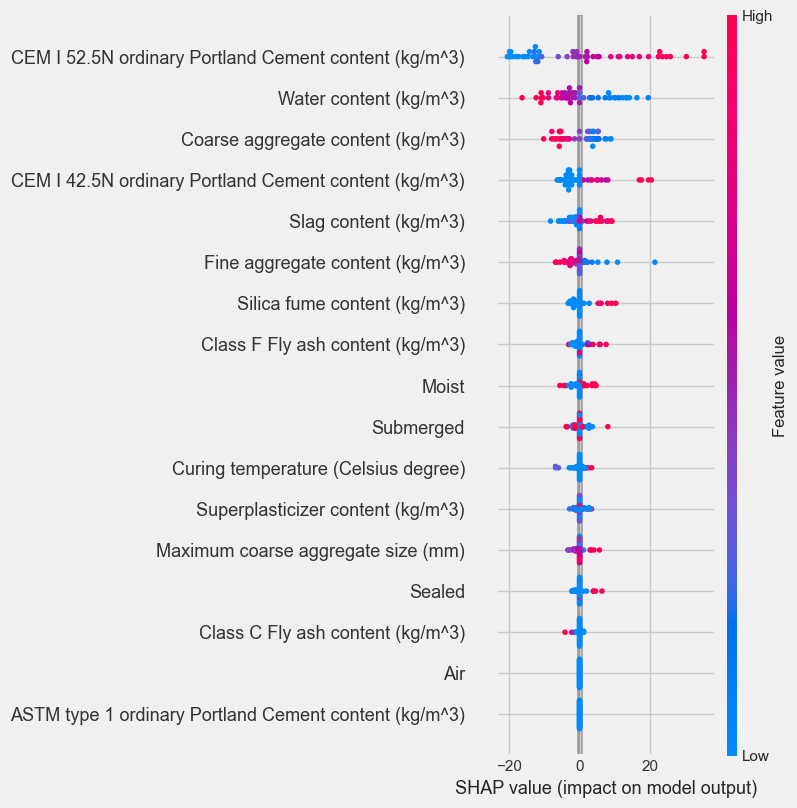

In [44]:
# Find the index of the selected label
selected_label_index = None
for i, label in enumerate(list_of_labels):
    if label == current_label.value:
        selected_label_index = i
        break

# Ensure that a valid index was found
if selected_label_index is None:
    raise ValueError("Selected label not found in list_of_labels")

# Now you can use the selected label index to access the corresponding values
selected_label = list_of_labels[selected_label_index]

print(f'Current label Shown: {selected_label}\n')

shap.summary_plot(shap_values=shap_values[selected_label_index],
                  features=X_test_scaled_df.iloc[0:51,:]
                  )

## Slump

In [45]:
# Create the list of all labels for the drop down list
list_of_labels = y.columns.to_list()

# Create a widget for the labels and then display the widget
current_label = widgets.Dropdown(options=list_of_labels,
                                 value='Slump (mm)',  # Set a default value if needed
                                 description='Select Label:'
                                 )

# Display the dropdown list (Note: access the label value with 'current_label.value')
current_label

Dropdown(description='Select Label:', options=('Slump (mm)', 'Average carbonation coefficient (mm/year^0.5)', …

In [46]:
# Find the index of the selected label
selected_label_index = None
for i, label in enumerate(list_of_labels):
    if label == current_label.value:
        selected_label_index = i
        break

# Ensure that a valid index was found
if selected_label_index is None:
    raise ValueError("Selected label not found in list_of_labels")

# Now you can use the selected label index to access the corresponding values
selected_label = list_of_labels[selected_label_index]

print(f'Current label Shown: {selected_label}')

shap.force_plot(base_value=explainer.expected_value[selected_label_index],
                shap_values=shap_value_single[selected_label_index],
                features=X_test_scaled_df.iloc[X_idx:X_idx+1,:]
                )

Current label Shown: Slump (mm)


Current label Shown: Slump (mm)


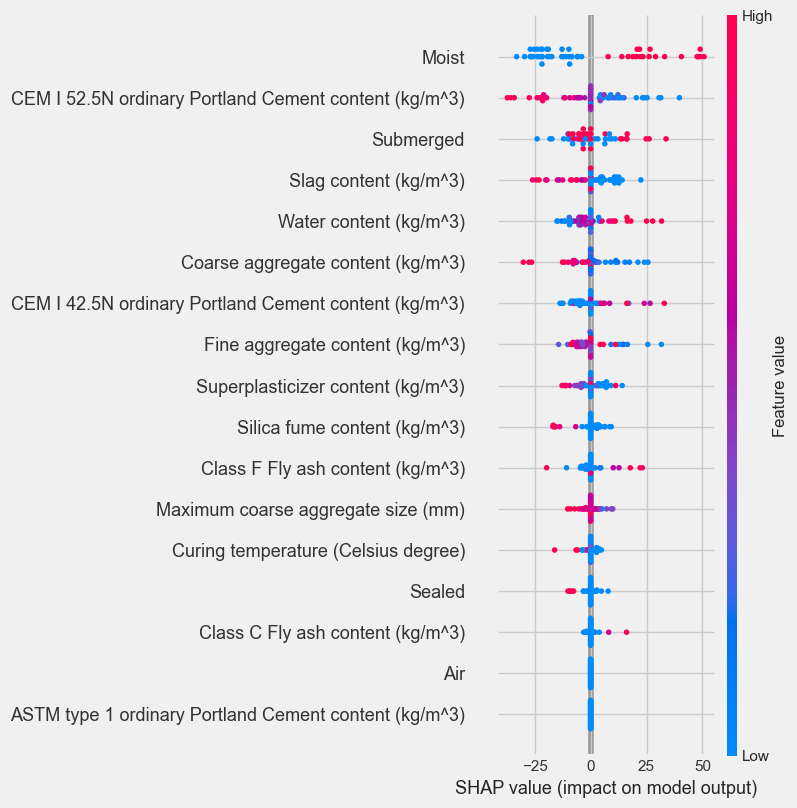

In [47]:
# Find the index of the selected label
selected_label_index = None
for i, label in enumerate(list_of_labels):
    if label == current_label.value:
        selected_label_index = i
        break

# Ensure that a valid index was found
if selected_label_index is None:
    raise ValueError("Selected label not found in list_of_labels")

# Now you can use the selected label index to access the corresponding values
selected_label = list_of_labels[selected_label_index]

print(f'Current label Shown: {selected_label}\n')

shap.summary_plot(shap_values=shap_values[selected_label_index],
                  features=X_test_scaled_df.iloc[0:51,:]
                  )

## Carbon Coefficient

In [48]:
# Create the list of all labels for the drop down list
list_of_labels = y.columns.to_list()

# Create a widget for the labels and then display the widget
current_label = widgets.Dropdown(options=list_of_labels,
                                 value='Average carbonation coefficient (mm/year^0.5)',  # Set a default value if needed
                                 description='Select Label:'
                                 )

# Display the dropdown list (Note: access the label value with 'current_label.value')
current_label

Dropdown(description='Select Label:', index=1, options=('Slump (mm)', 'Average carbonation coefficient (mm/yea…

In [49]:
# Find the index of the selected label
selected_label_index = None
for i, label in enumerate(list_of_labels):
    if label == current_label.value:
        selected_label_index = i
        break

# Ensure that a valid index was found
if selected_label_index is None:
    raise ValueError("Selected label not found in list_of_labels")

# Now you can use the selected label index to access the corresponding values
selected_label = list_of_labels[selected_label_index]

print(f'Current label Shown: {selected_label}')

shap.force_plot(base_value=explainer.expected_value[selected_label_index],
                shap_values=shap_value_single[selected_label_index],
                features=X_test_scaled_df.iloc[X_idx:X_idx+1,:]
                )

Current label Shown: Average carbonation coefficient (mm/year^0.5)


Current label Shown: Average carbonation coefficient (mm/year^0.5)


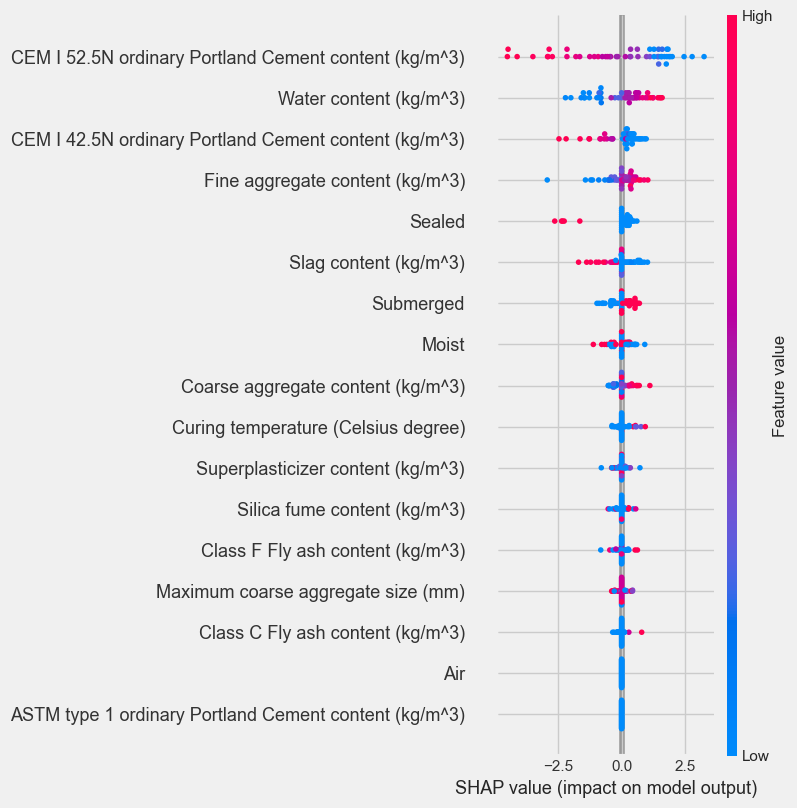

In [50]:
# Find the index of the selected label
selected_label_index = None
for i, label in enumerate(list_of_labels):
    if label == current_label.value:
        selected_label_index = i
        break

# Ensure that a valid index was found
if selected_label_index is None:
    raise ValueError("Selected label not found in list_of_labels")

# Now you can use the selected label index to access the corresponding values
selected_label = list_of_labels[selected_label_index]

print(f'Current label Shown: {selected_label}\n')

shap.summary_plot(shap_values=shap_values[selected_label_index],
                  features=X_test_scaled_df.iloc[0:51,:]
                  )